# Multiple Results Analysis

This notebook is intended to read a simulation results file with multiple simulations and results and create aggregate analyses and visualizations.

In [107]:
%matplotlib inline

import os
import sys 
import json
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from tabulate import tabulate
from operator import itemgetter
from itertools import groupby, chain
from collections import defaultdict, Counter

# Modify the Notebook path
sys.path.append(os.path.join(os.getcwd(), ".."))

In [108]:
sns.set_style('whitegrid')
sns.set_context('notebook')

In [109]:
# Specify a path to a results file 
# If None, will attempt to look one up
FIXTURES = os.path.join("..", "fixtures")
RESULTS  = os.path.join(FIXTURES, 'test-multi-results-crazy.json')

def get_results_data(path=RESULTS):
    with open(path, 'r') as f:
        return json.load(f)

# Load the data
data = get_results_data()

# Get all the values for a particular key 
def results_values(*key):
    for result in data:
        value = result
        for k in key:
            value = value.get(k, {})
        yield value

rvals = results_values

In [110]:
# Print report details 
def report_settings():
    table = defaultdict(list)
    exclude = frozenset([
        'valid_locations', 'invalid_types', 
        'default_replica', 'default_consistency', 'default_latency', 
        'max_sim_time', 'title', 'description',
        'election_timeout', 'heartbeat_interval',
    ])
    
    for idx, conf in enumerate(rvals('settings')):
        eid = "e{:0>2}".format(idx)
        for key, val in conf.iteritems():
            if key in exclude: continue 
            if key == 'anti_entropy_delay': key = 'anti_entropy'
            if idx == 0:
                table[''].append(key)
            table[eid].append(val)
    
    for idx, conf in enumerate(rvals('topology', 'meta')):
        eid = "e{:0>2}".format(idx)
        for key, val in conf.iteritems():
            if key in exclude: continue 
            if idx == 0:
                table[''].append(key)
            table[eid].append(val)

    return tabulate(table, headers='keys')

print report_settings()

               e19          e18          e11          e10          e13        e12       e15        e14        e17          e16         e91          e90          e93          e92          e95          e94          e97        e96       e99          e98         e142         e143         e140         e141         e128         e129         e124        e125         e126         e127         e120      e121       e122       e123       e08          e09          e06          e07          e04          e05          e02         e03          e00       e01        e86         e87          e84       e85        e82          e83          e80          e81          e88          e89          e139         e138         e137         e136         e135         e134        e133       e132      e131         e130         e79          e78          e73        e72       e71          e70          e77          e76          e75         e74        e108      e109       e102         e103         e100         e101         e1

In [111]:
def report_accesses(access='write'):
    table = defaultdict(list)
    
    for idx, results in enumerate(rvals('results')):
        counts = Counter()
        eid = "e{:0>2}".format(idx)
        
        for (rid, loc, ts) in results.get(access, []):
            counts[rid] += 1
            counts['total'] += 1
        
        for rid, count in sorted(counts.items(), key=itemgetter(0)):
            if idx == 0:
                table[''].append(rid)
            table[eid].append(count)
    
    print "{} Accesses:\n".format(access.capitalize())
    print tabulate(table, headers='keys')
    return table

table = report_accesses('read')

Read Accesses:

         e19    e18    e11    e10    e13    e12    e15    e14    e17    e16    e91    e90    e93    e92    e95    e94    e97    e96    e99    e98    e142    e143    e140    e141    e128    e129    e124    e125    e126    e127    e120    e121    e122    e123    e08    e09    e06    e07    e04    e05    e02    e03    e00    e01    e86    e87    e84    e85    e82    e83    e80    e81    e88    e89    e139    e138    e137    e136    e135    e134    e133    e132    e131    e130    e79    e78    e73    e72    e71    e70    e77    e76    e75    e74    e108    e109    e102    e103    e100    e101    e106    e107    e104    e105    e68    e69    e60    e61    e62    e63    e64    e65    e66    e67    e59    e58    e55    e54    e57    e56    e51    e50    e53    e52    e42    e43    e40    e41    e46    e47    e44    e45    e48    e49    e115    e114    e117    e116    e111    e110    e113    e112    e119    e118    e37    e36    e35    e34    e33    e32    e31    e30    e39    

In [112]:
table = report_accesses('write')

Write Accesses:

         e19    e18    e11    e10    e13    e12    e15    e14    e17    e16    e91    e90    e93    e92    e95    e94    e97    e96    e99    e98    e142    e143    e140    e141    e128    e129    e124    e125    e126    e127    e120    e121    e122    e123    e08    e09    e06    e07    e04    e05    e02    e03    e00    e01    e86    e87    e84    e85    e82    e83    e80    e81    e88    e89    e139    e138    e137    e136    e135    e134    e133    e132    e131    e130    e79    e78    e73    e72    e71    e70    e77    e76    e75    e74    e108    e109    e102    e103    e100    e101    e106    e107    e104    e105    e68    e69    e60    e61    e62    e63    e64    e65    e66    e67    e59    e58    e55    e54    e57    e56    e51    e50    e53    e52    e42    e43    e40    e41    e46    e47    e44    e45    e48    e49    e115    e114    e117    e116    e111    e110    e113    e112    e119    e118    e37    e36    e35    e34    e33    e32    e31    e30    e39   

In [113]:
def create_dataframe():
    table = []
    meta  = list(rvals('topology', 'meta'))

    for idx, results in enumerate(rvals('results')):
        data = {'eid': "e{:0>2}".format(idx)}
        data['variable (ms)'] = meta[idx]['variable']
        
        latency = meta[idx]['variable'].rstrip('ms').split('-')
        latency = sum(map(float, latency)) / 2
        
        data['mean latency (ms)'] = latency
        data['constant (ms)'] = meta[idx]['constant']
        data['users'] = 1
        for key, values in results.iteritems():
            if key == 'visibility latency':
                data['visibility latency (ms)'] = sum(v[3] - v[2] for v in values) / len(values)
                
            else:
                data[key] = len(values)
        table.append(data)
    
    return pd.DataFrame(table)

df = create_dataframe()
print df

    constant (ms)   eid  mean latency (ms)  read  stale reads  users  \
0          N/A ms   e00              198.5  1624           41      1   
1          N/A ms   e01              525.5  1580          190      1   
2          N/A ms   e02              852.5  1631          254      1   
3          N/A ms   e03             1179.5  1600          413      1   
4          N/A ms   e04             1506.5  1651          576      1   
5          N/A ms   e05             1833.5  1635          658      1   
6          N/A ms   e06             2160.5  1596          808      1   
7          N/A ms   e07             2487.5  1619          949      1   
8          N/A ms   e08             2814.5  1638         1014      1   
9          N/A ms   e09             3141.5  1625         1162      1   
10         N/A ms   e10             3468.5  1611         1177      1   
11         N/A ms   e11             3795.5  1630         1267      1   
12         N/A ms   e12              190.5  1644           54   

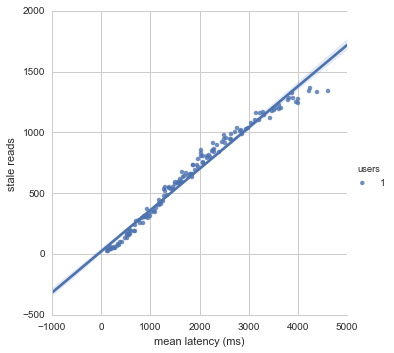

In [115]:
ax = sns.lmplot(x="mean latency (ms)", y="stale reads", hue='users', data=df)

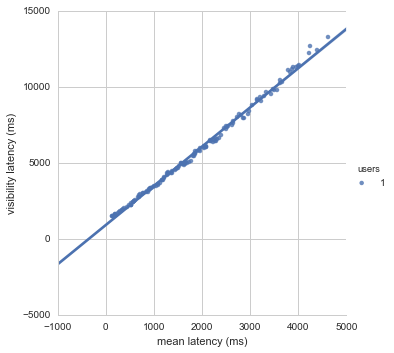

In [116]:
ax = sns.lmplot(x="mean latency (ms)", y="visibility latency (ms)", hue='users', data=df)